# Vorstellung der Agenten

## Simple_Agent_V1

###  Der <span style="font-size:26px; color:red;">Simple_Agent_V1</span>  folgt einer fest kodierten Entscheidungslogik basierend auf Schwellenwerten der aktuellen Prozessparameter (Temperaturgradient ΔT  & Wärmebehandlung ϑ). Obwohl er nicht lernen kann, nutzt er einfache Regeln, um gezielt Prüf- und Eingriffsaktionen zu wählen.

#### Entscheidungsstrategie: Regelbasiert, ohne Lernen
Logik:
- Ultraschallprüfung, wenn Temperaturgradient ΔT > 0.7 und Wärmebehandlung ϑ < 0.3
- Brinell, wenn nur Wärmebehandlung ϑ < 0.3
- Heizen, wenn Temperaturgradient zu niedrig (ΔT < 0.5)
- Wärmebehandlung, wenn sie knapp unter akzeptabel (ϑ < 0.6)
- Kühlen, wenn Temperaturgradient zu hoch (ΔT > 0.9)
- Sonst → Skip

Eigenschaften:

- Keine Zustandsverfolgung, rein reaktiv
- Reproduzierbares Verhalten bei gleichen Zuständen
- Dient als Baseline zur Bewertung lernender Agenten


--- SimpleAgentV1 ---
Durchschnittlicher Reward: 0.85
Skip: 6x
UT: 51x
Brinell: 19x
Heizen: 20x
Kühlen: 0x
Wärmebeh.: 40x


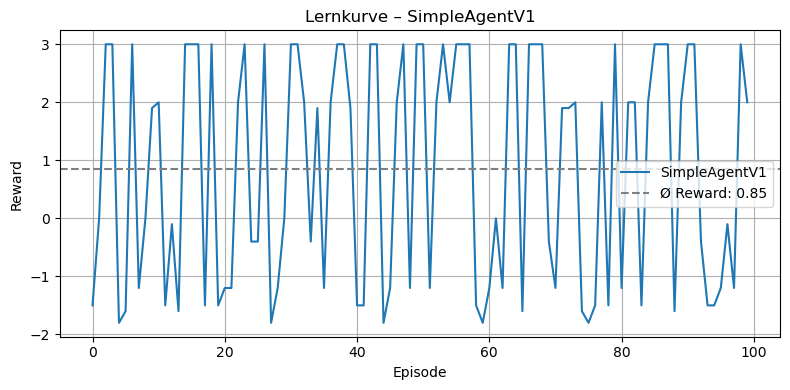

In [5]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from environments.env_wzl_0 import WzlPruefEnv2D
from rl_agent.agent_simple_v1 import SimpleAgentV1 # Dein Agent mit 6 Aktionen

# Initialisiere Umgebung und Agent
env = WzlPruefEnv2D()
agent = SimpleAgentV1(env.action_space)

# Evaluation
episodes = 100
rewards = []
action_counts = [0] * 6  # Für alle 6 Aktionen: 0-5

for ep in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        action_counts[action] += 1

    rewards.append(total_reward)

# Ergebnisse ausgeben
print("\n--- SimpleAgentV1 ---")
print(f"Durchschnittlicher Reward: {np.mean(rewards):.2f}")
aktionen = ["Skip", "UT", "Brinell", "Heizen", "Kühlen", "Wärmebeh."]
for i, count in enumerate(action_counts):
    print(f"{aktionen[i]}: {count}x")

# Plot
plt.figure(figsize=(8, 4))
plt.plot(rewards, label="SimpleAgentV1")
plt.axhline(np.mean(rewards), color="gray", linestyle="--", label=f"Ø Reward: {np.mean(rewards):.2f}")
plt.title("Lernkurve – SimpleAgentV1")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_simple_agent_v1.png")
plt.show()


## QLearningAgent_V1

### Entscheidungsstrategie: Q-Learning (Tabellenbasiertes RL)
Logik:

- Anfangs Exploration, später gezielte Entscheidungen (Exploitation)

- Lerneffekt über Belohnungssignal

- Ziel: Maximierung des langfristigen Rewards durch optimierte Prüfstrategie

### Dieser <span style="font-size:26px; color:red;">QLearningAgentV1</span> lernt durch Erfahrung: Er testet verschiedene Prüfstrategien und passt seine Entscheidungen mit jeder Episode basierend auf erhaltenen Rewards an. Am Ende nutzt er eine Q-Tabelle, um die bestmögliche Aktion für jeden Zustand zu wählen.

Starte Grid Search...

--- QLearningAgentV1---
Skip: 6x
UT: 51x
Brinell: 19x
Heizen: 20x
Kühlen: 0x
Wärmebeh.: 40x

--- Beste Parameterkombinationen ---
     Alpha  Gamma  EpsilonDecay  EpsilonMin  AvgRewardLast500
33     0.1   0.95         0.999        0.05            1.4456
81     0.2   0.95         0.999        0.05            1.3978
45     0.1   0.99         0.999        0.05            1.3870
102    0.3   0.90         0.998        0.05            1.3282
18     0.1   0.93         0.998        0.05            1.3264
46     0.1   0.99         0.999        0.10            1.3262
117    0.3   0.93         0.999        0.05            1.3154
129    0.3   0.95         0.999        0.05            1.3054
22     0.1   0.93         0.999        0.10            1.2896
34     0.1   0.95         0.999        0.10            1.2858


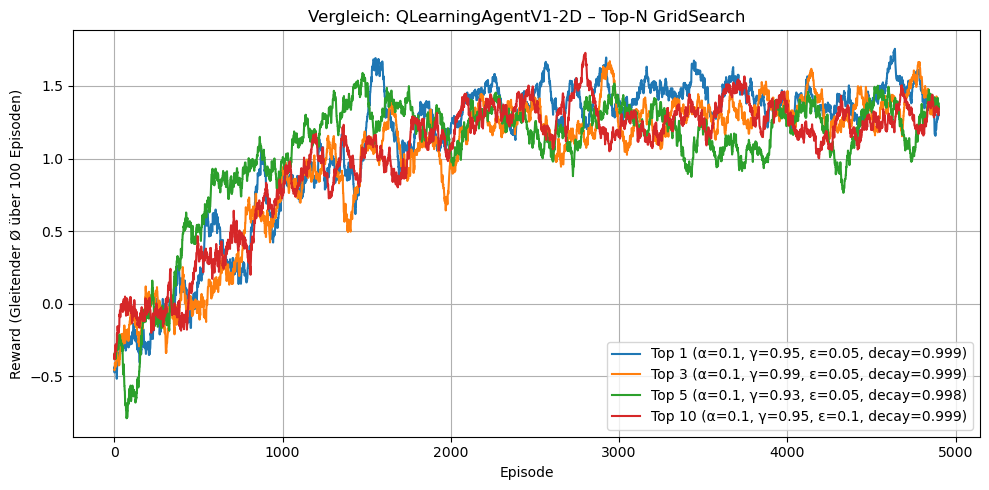

In [9]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from environments.env_wzl_0 import WzlPruefEnv2D
from rl_agent.q_learning_agent_V1 import QLearningAgentV1

# Initialisiere Umgebung
env = WzlPruefEnv2D()

# Grid Search Setup
alphas    = [0.1, 0.2, 0.3, 0.5]
gammas    = [0.90, 0.93, 0.95, 0.99]
decays    = [0.990, 0.995, 0.998, 0.999]
eps_min   = [0.05, 0.1, 0.2]

results = []
reward_histories = []

print("Starte Grid Search...")

for alpha, gamma, decay, epsilon_min in itertools.product(alphas, gammas, decays, eps_min):
    agent = QLearningAgentV1(
        state_space_shape=(10, 10),
        action_space=env.action_space,
        alpha=alpha,
        gamma=gamma,
        epsilon=1.0  # Startwert
    )
    agent.epsilon_min = epsilon_min
    agent.epsilon_decay = decay

    rewards = []
    for ep in range(5000):
        state = env.reset()
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        rewards.append(reward)

    avg_last = np.mean(rewards[-500:])
    results.append((alpha, gamma, decay, epsilon_min, avg_last))
    reward_histories.append((rewards, (alpha, gamma, decay, epsilon_min)))

# DataFrame zur Auswertung
df_best = pd.DataFrame(results, columns=["Alpha", "Gamma", "EpsilonDecay", "EpsilonMin", "AvgRewardLast500"])
df_best_sorted = df_best.sort_values(by="AvgRewardLast500", ascending=False)

# Ergebnisse ausgeben
print("\n--- QLearningAgentV1---")
aktionen = ["Skip", "UT", "Brinell", "Heizen", "Kühlen", "Wärmebeh."]
for i, count in enumerate(action_counts):
    print(f"{aktionen[i]}: {count}x")

print("\n--- Beste Parameterkombinationen ---")
print(df_best_sorted.head(10))

# Positionen der Top-N Kombinationen
top_positions = {
    "Top 1": 0,
    "Top 3": 2,
    "Top 5": 4,
    "Top 10": 9
}

# Plot
plt.figure(figsize=(10, 5))
window = 100

for label, pos in top_positions.items():
    if pos >= len(df_best_sorted):
        continue  # Falls nicht genug Kombinationen vorhanden sind
    idx = df_best_sorted.iloc[pos].name  # Ursprünglicher Index in reward_histories
    rewards, (alpha, gamma, decay, eps_min) = reward_histories[idx]
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f"{label} (α={alpha}, γ={gamma}, ε={eps_min}, decay={decay})")

plt.title("Vergleich: QLearningAgentV1-2D – Top-N GridSearch")
plt.xlabel("Episode")
plt.ylabel("Reward (Gleitender Ø über 100 Episoden)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_qlearning_topn.png", dpi=150)
plt.show()


## QLearningAgent_V2

### Dieser <span style="font-size:26px; color:red;">QLearningAgent_V2 </span> erweitert die klassische Q-Learning-Strategie, indem er neben dem aktuellen Zustand auch die letzte gewählte Aktion berücksichtigt. Dadurch entsteht ein detaillierteres Zustandsmodell, das dem Agenten erlaubt, reaktiver und kontextbezogener zu entscheiden. Ziel ist es, durch die zusätzliche Dimension (last_action) langfristig klügere Prüfpfade zu erlernen.

Starte Grid Search für QLearningAgentV2 (3D-State)...

--- Beste Parameterkombinationen für QLearningAgentV2 (3D-State) ---
     Alpha  Gamma  EpsilonDecay  EpsilonMin  AvgRewardLast500
118    0.3   0.93         0.999        0.10            1.5498
69     0.2   0.93         0.999        0.05            1.5474
28     0.1   0.95         0.995        0.10            1.5386
129    0.3   0.95         0.999        0.05            1.5192
82     0.2   0.95         0.999        0.10            1.5186
45     0.1   0.99         0.999        0.05            1.4762
22     0.1   0.93         0.999        0.10            1.4670
33     0.1   0.95         0.999        0.05            1.4644
9      0.1   0.90         0.999        0.05            1.4588
93     0.2   0.99         0.999        0.05            1.4562


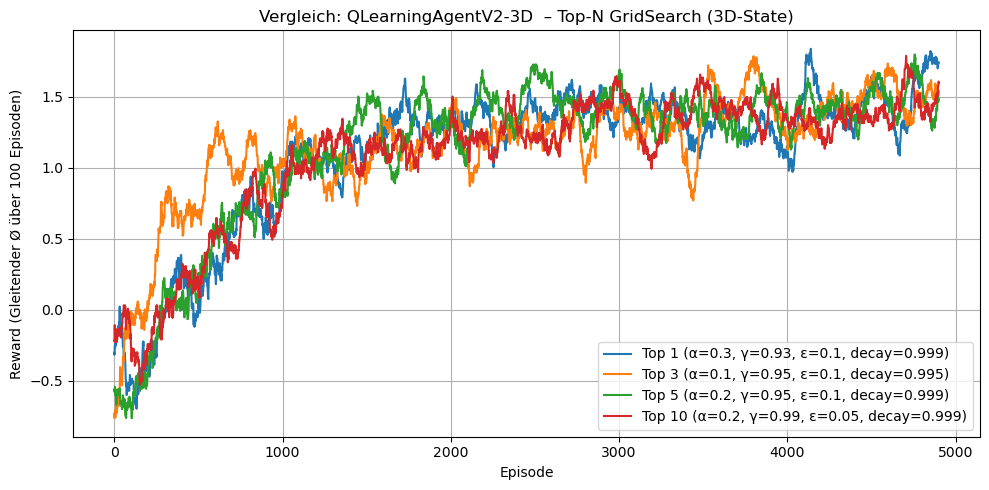

In [10]:
import sys
sys.path.append("..")

import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from environments.env_wzl_1 import WzlPruefEnv3D
from rl_agent.q_learning_agent_V2 import QLearningAgentV2  # 3D-fähiger Agent

# Umgebung
env = WzlPruefEnv3D()

# Grid Search Parameter
alphas    = [0.1, 0.2, 0.3, 0.5]
gammas    = [0.90, 0.93, 0.95, 0.99]
decays    = [0.990, 0.995, 0.998, 0.999]
eps_min   = [0.05, 0.1, 0.2]

results = []
reward_histories = []

print("Starte Grid Search für QLearningAgentV2 (3D-State)...")

# Durchlaufe alle Hyperparameter-Kombinationen
for alpha, gamma, decay, epsilon_min in itertools.product(alphas, gammas, decays, eps_min):
    agent = QLearningAgentV2(
        state_space_shape=(10, 10, 6),  # 3D: temperaturgradient x wärmebeh. x last_action
        action_space=env.action_space,
        alpha=alpha,
        gamma=gamma,
        epsilon=1.0
    )
    agent.epsilon_min = epsilon_min
    agent.epsilon_decay = decay

    rewards = []
    for ep in range(5000):
        state = env.reset()
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        rewards.append(reward)

    avg_last = np.mean(rewards[-500:])
    results.append((alpha, gamma, decay, epsilon_min, avg_last))
    reward_histories.append((rewards, (alpha, gamma, decay, epsilon_min)))

# Sortierung nach Performance
df_best = pd.DataFrame(results, columns=["Alpha", "Gamma", "EpsilonDecay", "EpsilonMin", "AvgRewardLast500"])
df_best_sorted = df_best.sort_values(by="AvgRewardLast500", ascending=False)

print("\n--- Beste Parameterkombinationen für QLearningAgentV2 (3D-State) ---")
print(df_best_sorted.head(10))

# Positionen der besten N Kombinationen
top_positions = {
    "Top 1": 0,
    "Top 3": 2,
    "Top 5": 4,
    "Top 10": 9
}

# Plot erzeugen
plt.figure(figsize=(10, 5))
window = 100

for label, pos in top_positions.items():
    if pos >= len(df_best_sorted):
        continue  # Sicherstellen, dass Index vorhanden ist
    idx = df_best_sorted.iloc[pos].name
    rewards, (alpha, gamma, decay, eps_min) = reward_histories[idx]
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f"{label} (α={alpha}, γ={gamma}, ε={eps_min}, decay={decay})")

plt.title("Vergleich: QLearningAgentV2-3D  – Top-N GridSearch (3D-State)")
plt.xlabel("Episode")
plt.ylabel("Reward (Gleitender Ø über 100 Episoden)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_qlearning_agent_v2_topn.png", dpi=150)
plt.show()


## DQNAgent

### Dieser <span style="font-size:26px; color:red;">DQNAgent</span> nutzt ein neuronales Netz, um Prüfstrategien in komplexen Zustandsräumen zu erlernen. Anders als beim tabellenbasierten Q-Learning approximiert der DQN die Q-Werte für kontinuierliche und hochdimensionale Zustände. Dadurch kann er auch in Umgebungen mit 4D-Zustandsinformationen effektiv lernen.

### Entscheidungsstrategie: Deep Q-Learning (Funktionapproximation)
Logik:

- Nutzung eines neuronalen Netzwerks zur Q-Wert-Schätzung
- Lernt aus Replay Buffer + periodischem Target-Network-Update
- Belohnungssignal steuert Netzwerkanpassung
- Vorteil gegenüber tabellenbasiertem RL: funktioniert auch bei kontinuierlichen, generalisierten Zuständen (z. B. [tg, wbh, last, prev])

In [21]:
import sys
sys.path.append("..")

import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import os

from environments.env_wzl_2 import WzlPruefEnv4D
from rl_agent.DQNAgent import DQNAgent  # 4D-fähiger Agent

# Initialisiere Umgebung
env = WzlPruefEnv4D()

# Grid Search Parameter
alphas    = [0.1, 0.2, 0.3]
gammas    = [0.90, 0.95, 0.99]
decays    = [0.995, 0.998, 0.999]
eps_min   = [0.05, 0.1]
episodes  = 100000
save_interval = 2500
state_shape = (10, 10, 6, 6)  # 4D-State: tg x wbh x last_action x prev_action
n_last_print = 10             # Nur die letzten X Episoden anzeigen

results = []
reward_histories = []

print("Starte Grid Search für DQNAgent (4D-State)...")

# Output-Ordner für Zwischenergebnisse
os.makedirs("qagent_v3_zwischenspeicher", exist_ok=True)

# Durchlaufe alle Kombinationen
for i, (alpha, gamma, decay, eps_min_val) in enumerate(itertools.product(alphas, gammas, decays, eps_min)):
    print("\n" + "="*60)
    print(f" Starte Kombination {i+1}/{len(alphas)*len(gammas)*len(decays)*len(eps_min)}:")
    print(f"α = {alpha}, γ = {gamma}, decay = {decay}, ε_min = {eps_min_val}")
    print("="*60)

    # Bisherige Ergebnisse sortieren (wenn vorhanden)
    if results:
        df_best = pd.DataFrame(results, columns=["Alpha", "Gamma", "EpsilonDecay", "EpsilonMin", "AvgRewardLast500"])
        df_best_sorted = df_best.sort_values(by="AvgRewardLast500", ascending=False)
        print("\n Beste Kombinationen bisher:")
        print(df_best_sorted.head(5).to_string(index=False))
        print("-" * 60)

    # Agent initialisieren
    agent = DQNAgent(
        state_space_shape=state_shape,
        action_space=env.action_space,
        alpha=alpha,
        gamma=gamma,
        epsilon=1.0,
        epsilon_decay=decay,
        epsilon_min=eps_min_val
    )

    rewards = []
    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            total_reward += reward
            state = next_state
        rewards.append(total_reward)

        # Ausgabe nur für die letzten n_last_print Episoden
        if ep >= episodes - n_last_print:
            print(f"[Ep {ep}] Reward: {total_reward:.2f}, avg_last_100: {np.mean(rewards[-100:]):.2f}")

        # Zwischenspeicherung
        if (ep + 1) % save_interval == 0:
            fname = f"qagent_v3_zwischenspeicher/rewards_alpha{alpha}_gamma{gamma}_decay{decay}_eps{eps_min_val}_ep{ep+1}.npy"
            np.save(fname, np.array(rewards))

    # Finale Speicherung
    avg_last = np.mean(rewards[-500:])
    results.append((alpha, gamma, decay, eps_min_val, avg_last))
    reward_histories.append((rewards, (alpha, gamma, decay, eps_min_val)))

    # Speichere vollständige Rewards dieser Kombination
    full_fname = f"qagent_v3_zwischenspeicher/rewards_FINAL_alpha{alpha}_gamma{gamma}_decay{decay}_eps{eps_min_val}.npy"
    np.save(full_fname, np.array(rewards))

# Endauswertung nach allen Kombinationen
df_best = pd.DataFrame(results, columns=["Alpha", "Gamma", "EpsilonDecay", "EpsilonMin", "AvgRewardLast500"])
df_best_sorted = df_best.sort_values(by="AvgRewardLast500", ascending=False)

print("\n" + "="*60)
print("  Beste Parameterkombinationen nach allen Durchläufen:")
print("="*60)
print(df_best_sorted.head(10).to_string(index=False))

# Exportiere CSV für spätere Analyse
df_best_sorted.to_csv("qagent_v3_best_results.csv", index=False)


Starte Grid Search für DQNAgent (4D-State)...

 Starte Kombination 1/54:
α = 0.1, γ = 0.9, decay = 0.995, ε_min = 0.05
[Ep 99990] Reward: 2.90, avg_last_100: 2.02
[Ep 99991] Reward: 2.00, avg_last_100: 2.02
[Ep 99992] Reward: 1.90, avg_last_100: 2.00
[Ep 99993] Reward: 2.00, avg_last_100: 2.00
[Ep 99994] Reward: 3.00, avg_last_100: 2.00
[Ep 99995] Reward: 3.00, avg_last_100: 2.04
[Ep 99996] Reward: 2.00, avg_last_100: 2.03
[Ep 99997] Reward: 2.00, avg_last_100: 2.03
[Ep 99998] Reward: 2.00, avg_last_100: 2.02
[Ep 99999] Reward: 2.00, avg_last_100: 2.02

 Starte Kombination 2/54:
α = 0.1, γ = 0.9, decay = 0.995, ε_min = 0.1

 Beste Kombinationen bisher:
 Alpha  Gamma  EpsilonDecay  EpsilonMin  AvgRewardLast500
   0.1    0.9         0.995        0.05            2.0278
------------------------------------------------------------
[Ep 99990] Reward: 2.00, avg_last_100: 1.85
[Ep 99991] Reward: 2.90, avg_last_100: 1.86
[Ep 99992] Reward: 2.00, avg_last_100: 1.86
[Ep 99993] Reward: 1.90, avg_l

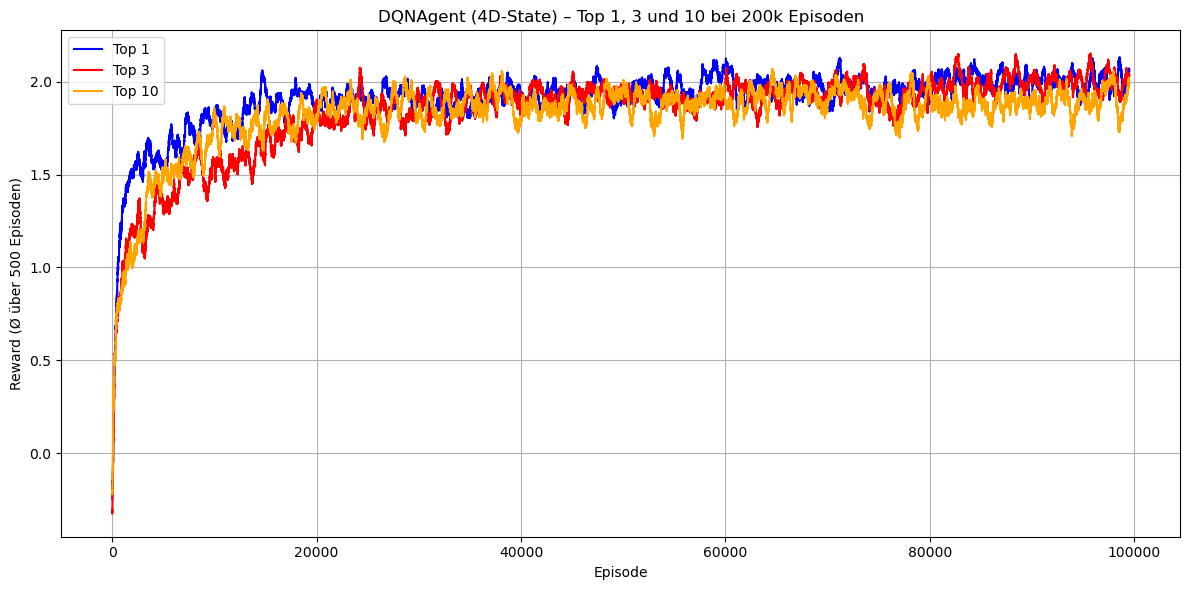

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Lade Ergebnisse
df_best = pd.read_csv("qagent_v3_best_results.csv")

# Welche Positionen anzeigen
positionen = {
    "Top 1": 0,
    "Top 3": 2,
    "Top 10": 9
}

farben = {
    "Top 1": "blue",
    "Top 3": "red",
    "Top 10": "orange"
}

window = 500
base_path = "qagent_v3_zwischenspeicher"

plt.figure(figsize=(12, 6))

for label, pos in positionen.items():
    if pos >= len(df_best):
        print(f" Nicht genug Einträge für {label}")
        continue

    row = df_best.iloc[pos]
    fname = f"rewards_FINAL_alpha{row.Alpha}_gamma{row.Gamma}_decay{row.EpsilonDecay}_eps{row.EpsilonMin}.npy"
    path = os.path.join(base_path, fname)

    if not os.path.exists(path):
        print(f" Datei fehlt: {path}")
        continue

    rewards = np.load(path)
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, color=farben[label], label=label)  # <-- hier fehlte die schließende Klammer und label

plt.title("DQNAgent (4D-State) – Top 1, 3 und 10 bei 200k Episoden")
plt.xlabel("Episode")
plt.ylabel(f"Reward (Ø über {window} Episoden)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_qlearning_agent_v3_top1_3_10_200k.png", dpi=150)
plt.show()
